In [1]:
from sympy import *
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
init_printing(use_latex='mathjax')

def clean(expr):
    if isinstance(expr,dict):
        return {k:clean(v) for k,v in expr.items()}
    elif isinstance(expr,list):
        return [clean(l) for l in expr]
    funcs = expr.atoms(Function)
    reps = {}
    for f in funcs:
        reps[f] = Symbol(f.name)
    return expr.subs(reps)

dropO = lambda s: sympify(str(s).replace('O','0 *'))


# Asymptotic Models

One thing a reader may have noticed if they have been running the code throughout is that it can take Sympy some time to solve our equations analytically, which is worrying considering that the equations given to Sympy to solve in these examples are quite simple, and could be done with relative ease by the mathematician. And this is true. But in the physical sciences, asmyptotics can be used to rigorously simplify models, and having a tool to automate those calculations allows the end user to spend time validating the model. This chapter will go over some examples of how Sympy can be used to derive these models

## Prandtl Boundary Layer Theory

This work on weakly viscous fluids near a boundary from 1905 is the original singular perturbation problem that can be treated by MMAE.

We begin with the non-dimensional, incompressible, two-dimensional Navier-Stokes equations $$u_t + uu_x + vu_y + p_x = \epsilon(u_{xx}+u_{yy}), \\ v_t + uv_x + vv_y + p_y = \epsilon(v_{xx}+v_{yy}), \\ u_x+v_y = 0,$$
where $\epsilon$ is the inverse Reynold's number, $u,v$ are the velocities in the $x,y$ directions, and $p$ is the pressure. The $\epsilon = 0$ case are known as the Euler equations. Since both are first order in time, they can both take the same initial conditions $u(x,y,0) = u_0(x,y), v(x,y,0) = v_0(x,y),$ and no initial condition is needed for the pressure. However, since the Euler and NS equations have different orders of spatial derivatives, different boundary conditions are required. The Euler equations require the no-flow condition $\langle u,v\rangle\cdot\mathbf{n}=0$ for normal vector $\mathbf{n},$ which negates velocities flowing out from a region. The Navier Stokes equations require the no-slip boundary conditions $\langle u,v\rangle = 0,$ negating both the tangential and normal velocities on the boundary.

In particular, we will consider a flat boundary at $y=0$ (the boundary layer is thin enough that the equations would not change for a smooth curved boundary).

The leading order outer solution becomes from the Euler equations obtained when $\epsilon = 0,$ which is located in $y>0$. We will denote the outer solution using lowercased variables. 

For the inner solution, we will use uppercased variables, which are unscaled except $Y = \frac y\delta, v = \gamma V.$ The following code will automate the generation of the scaled equations from our definitions. The leading order are the Prandtl boundary layer equations, but in code they are just the Prandtl equations.

Among the code are several filters streamline the process of substitution, one of which `scaling` is set to a null dictionary, with the actual scaling commented out. Looking at the expression, one arrives at the dominant balance $\gamma = \delta = \sqrt{\epsilon}$. By uncommenting the dictionary `scaling`, and the collect call on the inner line, one will arrive at the leading order outer and inner equations.

In [2]:
epsilon, nu = symbols('epsilon nu',real=True,positive=True)
x, y, t = symbols('x y t')
X, Y, T = symbols('X Y T',real=True,positive=True)

scales = symbols('delta0:2')
eps12 = epsilon**Rational(1,2)
scaling = {scales[0]:eps12,scales[1]:eps12}

outer_f = {c:Function(c)(x,y,t) for c in ['u','p','v']}
inner_f = {c:Function(c.upper())(X,Y,T) for c in ['u','p','v']}
s_filter = lambda d: {v:0 for v in d.values()}

v = outer_f['v'] + scales[0]*inner_f['v']
u = outer_f['u'] + inner_f['u']
p = outer_f['p'] + inner_f['p']

ddy = lambda f: f.diff(y) + f.diff(Y)/scales[1]
ddx = lambda f: f.diff(x) + f.diff(X)
ddt = lambda f: f.diff(t) + f.diff(T)

ns_eqns = {}
ns_eqns['xmom'] = ddt(u) + u*ddx(u) + v*ddy(u) + ddx(p) - epsilon*nu*(ddx(ddx(u)) + ddy(ddy(u)))
ns_eqns['ymom'] = ddt(v) + u*ddx(v) + v*ddy(v) + ddy(p) - epsilon*nu*(ddx(ddx(v)) + ddy(ddy(v)))
ns_eqns['div'] = ddx(u) + ddy(v)

euler_eqns = {k:eqn.subs(s_filter(inner_f)|scaling) \
        .expand().simplify() \
        .collect(epsilon,evaluate=False) \
        for k, eqn in ns_eqns.items()}
for eqn in euler_eqns.values():
    display(clean(eqn))

prandtl_eqns = {k:eqn.subs(s_filter(outer_f)|scaling) \
        .expand().simplify() \
        .collect(epsilon,evaluate=False) \
        for k, eqn in ns_eqns.items()}
for eqn in prandtl_eqns.values():
    display(clean(eqn))

#reduce to the leading order equations
for k,val in {'xmom':1,'ymom':1/eps12,'div':1}.items():
    prandtl_eqns[k] = prandtl_eqns[k][val]

⎧                                              2          2    ⎫
⎪     d         d       d       d             d          d     ⎪
⎨1: u⋅──(u) + v⋅──(u) + ──(p) + ──(u), ε: - ν⋅───(u) - ν⋅───(u)⎬
⎪     dx        dy      dx      dt              2          2   ⎪
⎩                                             dx         dy    ⎭

⎧                                              2          2    ⎫
⎪     d         d       d       d             d          d     ⎪
⎨1: u⋅──(v) + v⋅──(v) + ──(p) + ──(v), ε: - ν⋅───(v) - ν⋅───(v)⎬
⎪     dx        dy      dy      dt              2          2   ⎪
⎩                                             dx         dy    ⎭

⎧   d       d    ⎫
⎨1: ──(u) + ──(v)⎬
⎩   dx      dy   ⎭

⎧                          2                             2    ⎫
⎪     d         d         d        d       d            d     ⎪
⎨1: U⋅──(U) + V⋅──(U) - ν⋅───(U) + ──(P) + ──(U), ε: -ν⋅───(U)⎬
⎪     dX        dY          2      dX      dT             2   ⎪
⎩                         dY                            dX    ⎭

⎧                                      2                        2    ⎫
⎪1   d            d         d         d        d       3/2     d     ⎪
⎨──: ──(P), √ε: U⋅──(V) + V⋅──(V) - ν⋅───(V) + ──(V), ε   : -ν⋅───(V)⎬
⎪√ε  dY           dX        dY          2      dT                2   ⎪
⎩                                     dY                       dX    ⎭

⎧   d       d    ⎫
⎨1: ──(U) + ──(V)⎬
⎩   dX      dY   ⎭

This scaling demonstrates the different dynamics away from and at the boundary layer respectively. 

For our continued analysis, we will not need the Euler equations. A number of similarity solutions to the Prandtl equations have been bound, which means that th solutions have the same structure up to some scaling factors, reducing this system of PDEs to simpler nonlinear ODEs. For our purpose, we will only examine one of these, the

## Blasius boundary layer

The Blasius boundary layer makes to assumptions to the Prandtl equations:
- $\frac{d}{dT} = 0$, or the equations are *steady* (true for the Prandtl equations)
- $\frac{dP}{dX} = 0$, or the pressure does not change parallel to the wall

In which case, the Prandtl $x$-momentum is invariant under the transformation $x\to c^2x, y\to cy, u\to u, v\to \frac vc,$ for some $c>0.$

In [3]:
#make blasius assumptions
blasius_subs = {inner_f['p'].diff(X):0,inner_f['u'].diff(T):0} 
steady_prandtl_eqns = {k:v.subs(blasius_subs).simplify() for k,v in prandtl_eqns.items()}
display(clean(list(steady_prandtl_eqns.values())))

⎡                       2                          ⎤
⎢  d         d         d       d      d       d    ⎥
⎢U⋅──(U) + V⋅──(U) - ν⋅───(U), ──(P), ──(U) + ──(V)⎥
⎢  dX        dY          2     dY     dX      dY   ⎥
⎣                      dY                          ⎦

One simplification that we will use is that of the *streamfunction* $\psi,$ which is setup to define $U = \psi_Y, v = -\psi_X,$ automatically ensuring $U_X + V_Y = 0.$ With this in mind, he introduced some self-similar variables $$\psi := \sqrt{\nu U_\infty X}f(\eta),\\\eta := Y\sqrt{U_\infty/\nu X},$$ where $U_\infty:=\lim_{X\to\infty}U$ is the freestream velocity, where $f'$ defines a streamfunction profile. 

Taking these variables and makin the appropriate substitutions, we arrive at the Blasius equation

In [4]:
U_oo = symbols('U_\\infty',real=True,positive=True)
eta_conversion = Y*sqrt(U_oo/(nu * X))
profile = Function('f')(eta_conversion)
stream_function = sqrt(nu*U_oo*X)*profile
stream_sub = {inner_f['u']:stream_function.diff(Y).simplify(),inner_f['v']:-stream_function.diff(X)}
blasius = (steady_prandtl_eqns['xmom'].subs(stream_sub)\
            .expand().simplify()\
            .subs(eta_conversion,Symbol('eta'))*(-2*X/U_oo**2)).simplify()
display(blasius)

      2             3       
     d             d        
f(η)⋅───(f(η)) + 2⋅───(f(η))
       2             3      
     dη            dη       

This equation has two common sets of boundary conditions. Those on $f$ describe $v$, and those on $f'$ describe u. 
- The natural boundary conditions used by Blasius are $$f(0)=0,f'(0)=0, f'(\infty) = 1,$$ which are the no-flux, no-slip, and matching conditions respectively to describe the effects of a fluid moving over a stationary plate. 
- There are also the boundary conditions of Sakiadis $$f(0)=0,f'(0)=1,f'(\infty)=0,$$ where now the boundary itself moves with slip in a stationary fluid. 

In both cases, one can build series solutions $f_{sB},f_{sS}$ about $\eta = 0,$ where both solutions strongly depends upon the wall shear parameter $\kappa\equiv f''(0).$ We build both series out below

In [5]:
eta, kappa = symbols('eta kappa')
profile = Function('f')(eta)
N = 14
a_ = symbols(f'a0:{N}')
f_s = sum([a_[n]*eta**n for n in range(N)])

blasius_series_eqns = blasius.subs(profile,f_s) \
    .simplify().expand().collect(eta,evaluate=False)

blasius_s_coeffs = {a_[0]:0,a_[1]:0,a_[2]:kappa/2}
sakiadis_s_coeffs = {a_[0]:0,a_[1]:1,a_[2]:kappa/2}
for i in range(N-3):
    blasius_s_coeffs[a_[i+3]] = solve(blasius_series_eqns[eta**i].subs(blasius_s_coeffs),a_[i+3])[0]
    sakiadis_s_coeffs[a_[i+3]] = solve(blasius_series_eqns[eta**i].subs(sakiadis_s_coeffs),a_[i+3])[0]

f_s_blasius = f_s.subs(blasius_s_coeffs)
f_s_sakiadis = f_s.subs(sakiadis_s_coeffs)
display(Eq(Symbol('f_{sB}'),f_s_blasius))
display(Eq(Symbol('f_{sS}'),f_s_sakiadis))


              11  4       8  3    5  2    2  
           5⋅η  ⋅κ    11⋅η ⋅κ    η ⋅κ    η ⋅κ
f_{sB} = - ──────── + ──────── - ───── + ────
           4257792     161280     240     2  

          13  2 ⎛       2       ⎞       ⎛   3             ⎞    11  2 ⎛         ↪
         η  ⋅κ ⋅⎝18598⋅κ  - 9385⎠    12 ⎜  κ         κ    ⎟   η  ⋅κ ⋅⎝587 - 25 ↪
f_{sS} = ──────────────────────── + η  ⋅⎜────── - ────────⎟ + ──────────────── ↪
               66421555200              ⎝725760   16220160⎠         212889600  ↪

↪    2⎞    10   ⎛        2⎞       9  2    8   ⎛    2     ⎞       7  2    6     ↪
↪ 0⋅κ ⎠   η  ⋅κ⋅⎝7 - 50⋅κ ⎠   43⋅η ⋅κ    η ⋅κ⋅⎝22⋅κ  - 15⎠   11⋅η ⋅κ    η ⋅κ   ↪
↪ ───── + ───────────────── - ──────── + ───────────────── + ──────── + ──── - ↪
↪              3870720         967680         322560          20160     960    ↪

↪   5  2    4      2      
↪  η ⋅κ    η ⋅κ   η ⋅κ    
↪  ───── - ──── + ──── + η
↪   240     48     2      

This next batch of code is an symbolic-based implementation of Newton's method, which we will use to solve some upcoming nonlinear systems.

In [36]:
def sympy_newton(f,x_sym,x_0,iter_max=100,f_type=np.float64,tol=None):
    tol = 10*np.finfo(f_type).eps if tol is None else tol
    x_0 = [[i] for i in x_0]
    f = Matrix(f)
    J = Matrix([[f_i.diff(x_j) for x_j in x_sym] for f_i in f])
    x = Matrix(x_sym)
    iter_reached = True
    for _ in range(iter_max):
        x_dict = {x[i]:x_0[i][0] for i in range(len(x))}
        J_n = np.array(J.subs(x_dict)).astype(f_type)
        f_n = np.array(f.subs(x_dict)).astype(f_type)
        if np.linalg.norm(f_n.transpose()) < tol:
            iter_reached = False
            break
        x_n = np.array(x.subs(x_dict)).astype(f_type)
        x_0 = x_n - np.linalg.solve(J_n,f_n) #newton iteration
    if iter_reached:
        print(f'Max iterations ({iter_max}) reached.')
    return x_0.transpose().flatten().tolist()

The following technique to approximate the solutions to these problems comes from Barlow et. al. (2017) where instead of a power series, an asymptotic approximant is used to get the desired asymptoic behaviors as $\eta\to\infty$. So for the Blasius problem we get the approximant $$f_{AB} = \eta + C - \frac{C}{1+\sum_{n=1}^N A_n\eta^n},$$ and for the Sakiadis problem we get $$f_{AS} = C - \frac{C}{1+\sum_{n=1}^N A_n\eta^n},$$ where $C$ in both cases captures an offset from the simplest behaviors $\eta$ and $0$ respectively.

Then what is dones is that we assume that $f_A = f_s$ for the first $N$ terms in a $\eta$ power series expansion of both, with $A_{N-2} = A_{N-1} = 0,$ leaving a system of equations over $\{A_{i}\}_{i=0}^{N-3}, \kappa$ and $C$. What we do next is reduce this system to a 2 by 2 system over $kappa,C,$ which is solved by `sympy_newton` above. Since this document is not about numerical analysis, we will say nothing about the accuracy and sensitivity of this method. In fact, one of the aims of this work is to promote the idea of unifying symbolic computation with more traditional numerical computations.

From this, we can generate calculable expressions for both $f_As$, which is displayed at the end of the code

In [23]:
A_ = symbols(f'A0:{N}')
C = symbols('C')
f_A_sakiadis = C - C/(1+sum([A_[n]*eta**n for n in range(1,N)]))
f_A_blasius = eta + C - C/(1+sum([A_[n]*eta**n for n in range(1,N)]))

sakiadis_A_eqn = dropO(f_s_sakiadis - series(f_A_sakiadis,eta,n=N))\
    .expand().powsimp().collect(eta,evaluate=False)
blasius_A_eqn = dropO(f_s_blasius - series(f_A_blasius,eta,n=N))\
    .expand().powsimp().collect(eta,evaluate=False)
#[display(Eq(O(k),v)) for k,v in sakiadis_A_eqn.items()]

sakiadis_A_coeffs = {A_[N-1]:0,A_[N-2]:0}
blasius_A_coeffs = {A_[N-1]:0,A_[N-2]:0}
for n in range(1,N-2):
    s = solve(sakiadis_A_eqn[eta**n].subs(sakiadis_A_coeffs),A_[n])
    sakiadis_A_coeffs[A_[n]] = s[0]
    s = solve(blasius_A_eqn[eta**n].subs(blasius_A_coeffs),A_[n])
    blasius_A_coeffs[A_[n]] = s[0]


sakiadis_A_p = [(sakiadis_A_eqn[eta**(N-1)].subs(sakiadis_A_coeffs)*C**(N-2)).expand().simplify(),\
(sakiadis_A_eqn[eta**(N-2)].subs(sakiadis_A_coeffs)*C**(N-3)).expand().simplify()]
blasius_A_p = [(blasius_A_eqn[eta**(N-1)].subs(blasius_A_coeffs)*C**(N-2)).expand().simplify(),\
(blasius_A_eqn[eta**(N-2)].subs(blasius_A_coeffs)*C**(N-3)).expand().simplify()]

sakiadis_A_coeffs[kappa], sakiadis_A_coeffs[C] = sympy_newton(sakiadis_A_p,[kappa,C],[-0.5,1.5])
blasius_A_coeffs[kappa], blasius_A_coeffs[C] = sympy_newton(blasius_A_p,[kappa,C],[0.332,-1.721])

f_A_sakiadis = f_A_sakiadis.subs(sakiadis_A_coeffs)
f_A_blasius = f_A_blasius.subs(blasius_A_coeffs)

display(Eq(Symbol('f_{AS}'),f_A_sakiadis))
display(Eq(Symbol('f_{AB}'),f_A_blasius))

                                                                               ↪
f_{AS} = 1.73097675578546 - ────────────────────────────────────────────────── ↪
                                                 11                        10  ↪
                            1.29389315645905e-8⋅η   + 1.79049516678273e-7⋅η    ↪

↪                                                                              ↪
↪ ──────────────────────────────────────────────────────────────────────────── ↪
↪                        9                        8                        7   ↪
↪ + 1.17356051103746e-6⋅η  + 4.15632354541974e-6⋅η  + 7.44044870965781e-6⋅η  + ↪

↪   1.73097675578546                                                           ↪
↪ ──────────────────────────────────────────────────────────────────────────── ↪
↪                       6                         5                        4   ↪
↪  2.68120851953251e-5⋅η  + 0.000596949964396278⋅η  + 0.00707681444761763⋅η  + ↪

↪                        

                                                                               ↪
f_{AB} = η - 1.81795203095548 + ────────────────────────────────────────────── ↪
                                                    11                         ↪
                                3.8991684640649e-8⋅η   + 5.39729750801887e-7⋅η ↪

↪                                                                              ↪
↪ ──────────────────────────────────────────────────────────────────────────── ↪
↪ 10                        9                        8                       7 ↪
↪    + 4.75133447558433e-6⋅η  + 3.30740896985712e-5⋅η  + 0.0001960994141443⋅η  ↪

↪     1.81795203095548                                                         ↪
↪ ──────────────────────────────────────────────────────────────────────────── ↪
↪                         6                        5                       4   ↪
↪  + 0.00101919019336121⋅η  + 0.00470477503410937⋅η  + 0.0192518275243717⋅η  + ↪

↪                        

This next block plots the different solutions to the different equations, followed by the residuals ($2f_A''' + f_Af_A''$) for both versions of $f_A$ 

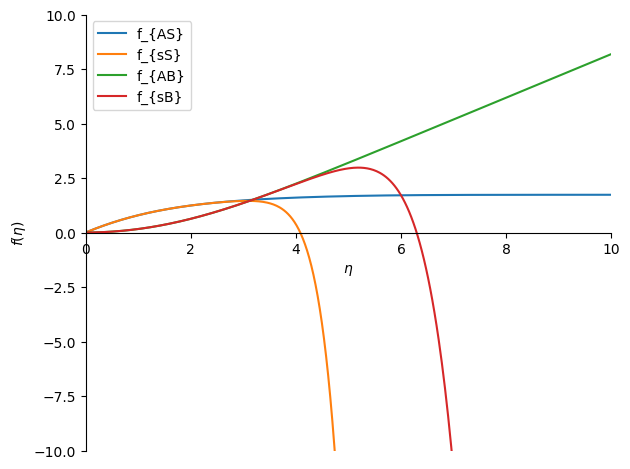

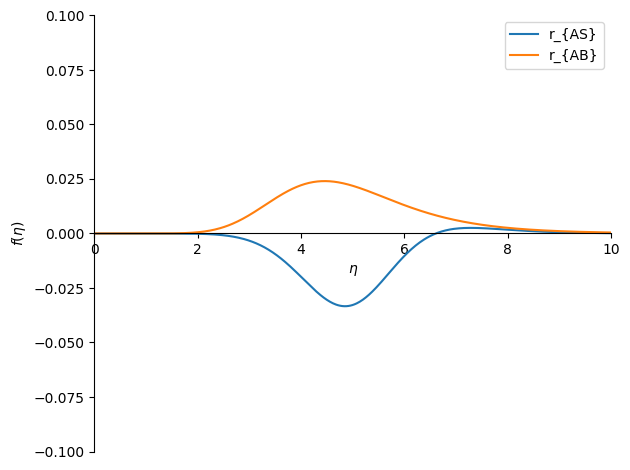

In [34]:
p = plotting.plot(f_A_sakiadis,xlim=(0,10),ylim=(-10,10),show=False,legend=True,label='f_{AS}')
p.extend(plotting.plot(f_s_sakiadis.subs(sakiadis_A_coeffs),show=False,label='f_{sS}'))
p.extend(plotting.plot(f_A_blasius,show=False,label='f_{AB}'))
p.extend(plotting.plot(f_s_blasius.subs(blasius_A_coeffs),show=False,label='f_{sB}'))
p.show()
p = plotting.plot(blasius.subs(profile,f_A_sakiadis).simplify(),xlim=(0,10),ylim=(-0.1,0.1),show=False,legend=True,label='r_{AS}')
p.extend(plotting.plot(blasius.subs(profile,f_A_blasius).simplify(),show=False,label='r_{AB}'))
p.show()